In [18]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from pytorch3d.loss import chamfer_distance
from RGB_model import PointCloudAE
from Dataloadersv2 import GetDataLoaders
import RGB_utils as utils
import matplotlib.pyplot as plt
import random
import math

# Configuration
batch_size = 32
output_folder = os.path.expanduser("~/meoutputsv2_2.2/")
os.makedirs(output_folder, exist_ok=True)
save_results = True
use_GPU = True
latent_size = 128
fixed_size = 1028

# Utility functions
def generate_random_function():
    functions = [
        lambda x, y, z: (x + y + z) % 1.0,
        lambda x, y, z: (math.sin(x) + math.cos(y) + z) % 1.0,
        lambda x, y, z: (x * y * z) % 1.0,
        lambda x, y, z: ((x**2 + y**2 + z**2)**0.5) % 1.0,
    ]
    return random.choice(functions)

def normalize_point_cloud(pc_array):
    normalized_pc_array = []
    for pc in pc_array:
        spatial_coords = pc[:, :3]
        centroid = np.mean(spatial_coords, axis=0)
        spatial_coords -= centroid
        d_max = np.max(np.linalg.norm(spatial_coords, axis=1))
        if d_max > 0:
            spatial_coords /= d_max
        pc[:, :3] = spatial_coords
        normalized_pc_array.append(pc)
    return np.array(normalized_pc_array)

def assign_color_to_point_clouds(pc_array):
    colored_pc_array = []
    for pc in pc_array:
        r_func, g_func, b_func = generate_random_function(), generate_random_function(), generate_random_function()
        rgb_values = np.array([
            [max(0, min(1, r_func(x, y, z))),
             max(0, min(1, g_func(x, y, z))),
             max(0, min(1, b_func(x, y, z)))]
            for x, y, z in pc
        ])
        colored_pc = np.hstack((pc, rgb_values))
        colored_pc_array.append(colored_pc)
    return np.array(colored_pc_array)

def adjust_point_clouds(pc_array, fixed_size=1028):
    adjusted_pc_array = []
    for pc in pc_array:
        num_points = pc.shape[0]
        if num_points < fixed_size:
            indices = np.random.choice(num_points, fixed_size - num_points, replace=True)
            upsampled_points = pc[indices, :]
            adjusted_pc = np.vstack((pc, upsampled_points))
        elif num_points > fixed_size:
            indices = np.random.choice(num_points, fixed_size, replace=False)
            adjusted_pc = pc[indices, :]
        else:
            adjusted_pc = pc
        adjusted_pc_array.append(adjusted_pc)
    return np.array(adjusted_pc_array)

# Load, normalize, and prepare point clouds
def preprocess_point_clouds(input_path, output_path, fixed_size=1028):
    pc_array = np.load(input_path, allow_pickle=True)
    colored_pc_array = assign_color_to_point_clouds(pc_array)
    adjusted_pc_array = adjust_point_clouds(colored_pc_array, fixed_size=fixed_size)
    normalized_pc_array = normalize_point_cloud(adjusted_pc_array)
    
    np.save(output_path, normalized_pc_array)
    return normalized_pc_array

# Load datasets
test_path = "data/ModelNet10/alltest.npy"
train_path = "data/ModelNet10/alltrain.npy"
test_output_path = "data/alltest_adjusted.npy"
train_output_path = "data/alltrain_adjusted.npy"

adjusted_pc_test_array = preprocess_point_clouds(test_path, test_output_path, fixed_size=fixed_size)
adjusted_pc_train_array = preprocess_point_clouds(train_path, train_output_path, fixed_size=fixed_size)

# Load DataLoaders
train_loader, test_loader = GetDataLoaders(
    train_source =train_output_path,
    test_source =test_output_path,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)

# Initialize the network
point_size = fixed_size
net = PointCloudAE(point_size, latent_size)
if os.path.isfile("Generalv2_1028RGBpc_Encoder.pth"):
    net.load_state_dict(torch.load("Generalv2_1028RGBpc_Encoder.pth"))
    print("Loaded saved model weights.")
else:
    print("No saved model weights found. Starting from scratch.")

device = torch.device("cuda:0" if use_GPU and torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    net = torch.nn.DataParallel(net)
net = net.to(device)

# Training setup
optimizer = optim.Adam(net.parameters(), lr=0.0006)

# Loss function
def combined_loss(pred, target):
    pred_spatial, pred_color = pred[..., :3], pred[..., 3:]
    target_spatial, target_color = target[..., :3], target[..., 3:]
    spatial_loss, _ = chamfer_distance(pred_spatial, target_spatial)
    color_loss, _ = chamfer_distance(pred_color, target_color)
    return spatial_loss + color_loss

def train_epoch():
    net.train()
    epoch_loss = 0

    # Loop over the data returned by the DataLoader
    for i, batch in enumerate(train_loader):
        # Handle the batch structure
        if isinstance(batch, (tuple, list)):  # If train_loader returns tuples
            data = batch[0]  # Extract the data
        else:
            data = batch  # If train_loader returns only the data

        # Move data to the device (GPU/CPU)
        data = data.to(device)

        # Zero the optimizer gradients
        optimizer.zero_grad()

        # Pass the data through the network (transpose for N, C, L format)
        output = net(data.permute(0, 2, 1))

        # Compute the loss
        loss = combined_loss(output, data)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()

    # Return the average loss
    return epoch_loss / len(train_loader)


def test_epoch():
    net.eval()  # Set the network to evaluation mode
    epoch_loss = 0

    with torch.no_grad():  # Disable gradient computation
        for i, batch in enumerate(test_loader):
            # Handle the batch structure
            if isinstance(batch, (tuple, list)):  # If test_loader returns tuples
                data = batch[0]  # Extract the data
            else:
                data = batch  # If test_loader returns only the data

            # Move data to the device (GPU/CPU)
            data = data.to(device)

            # Pass the data through the network (transpose for N, C, L format)
            output = net(data.permute(0, 2, 1))

            # Compute the loss
            loss = combined_loss(output, data)

            # Accumulate the loss
            epoch_loss += loss.item()

    # Return the average loss
    return epoch_loss / len(test_loader)

train_loss_list = []  
test_loss_list = []  
loss_list = []
counter = 0

for i in range(100) :

    startTime = time.time()
    
    train_loss = train_epoch() #train one epoch, get the average loss
    train_loss_list.append(train_loss)
    
    test_loss = test_epoch() # test with test set
    test_loss_list.append(test_loss)
    
    epoch_time = time.time() - startTime
    
    writeString = "epoch " + str(i) + " train loss : " + str(train_loss) + " test loss : " + str(test_loss) + " epoch time : " + str(epoch_time) + "\n"
    
    #increments counter
    counter += 1

    #prints and saves loss of every 20th iteration
    loss_list.append(train_loss)
    if counter % 20 == 0:
        print(f'Iteration {counter}, Loss: {train_loss}')
        print(output_folder)
        torch.save(net.state_dict(), 'Generalv2_1028pc_Encoder.pth')
    # plot train/test loss graph
    plt.plot(train_loss_list, label="Train")
    plt.plot(test_loss_list, label="Test")
    plt.legend()

    if(save_results): # save all outputs to the save folder

        # write the text output to file
        with open(output_folder + "prints.txt","a") as file: 
            
            file.write(writeString)

        # update the loss graph
        plt.savefig(output_folder + "loss.png")
        plt.close()

        # save input/output as image file
        if(i%50==0):
            
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_test_set"))

            #If you wanted to plot the training outputs aswell
            #train_samples = next(iter(train_loader))
            #loss , train_output = test_batch(train_samples)
            #utils.plotPCbatch(train_samples, train_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_train_set"))
    else : # display all outputs
        
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_test_set"))

            
            train_samples = next(iter(train_loader))
            loss , train_output = test_batch(train_samples)
            utils.plotPCbatch(train_samples, train_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_train_set"))

            print(writeString)

            plt.show()

    #Added a clear cache for me gpu
    torch.cuda.empty_cache()


/tmp/ipykernel_15051/954519885.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(colored_pc_array)


No saved model weights found. Starting from scratch.
Epoch 0: Train Loss = 0.08046631747484208, Test Loss = 0.058023523153929876
Epoch 1: Train Loss = 0.048038505166769024, Test Loss = 0.043173467033895956
Epoch 2: Train Loss = 0.03969172528386116, Test Loss = 0.03834971991078607
Epoch 3: Train Loss = 0.035940084233880044, Test Loss = 0.034566524920278584
Epoch 4: Train Loss = 0.03309591144323349, Test Loss = 0.03344984673734369
Epoch 5: Train Loss = 0.031143112570047378, Test Loss = 0.030333407608599497
Epoch 6: Train Loss = 0.029344570577144624, Test Loss = 0.029216234989721198
Epoch 7: Train Loss = 0.02818850176036358, Test Loss = 0.028969273741902977
Epoch 8: Train Loss = 0.02687857748568058, Test Loss = 0.028168788051296925
Epoch 9: Train Loss = 0.02623777964711189, Test Loss = 0.0271493059679352
Epoch 10: Train Loss = 0.025576865285634996, Test Loss = 0.02604834189445808
Epoch 11: Train Loss = 0.024650738373398783, Test Loss = 0.025630950542359518
Epoch 12: Train Loss = 0.0244969

KeyboardInterrupt: 

In [3]:
#Note to self: I changed the fig_count to 2 
#and am doing normalizing instead of padding for constant 
#number of points 
import os
import numpy as np
import time
import math
import random
import RGB_utils as utils
import matplotlib.pyplot as plt
from RGB_model import PointCloudAE
from RGB_Dataloaders import GetDataLoaders
import torch
import torch.optim as optim
import torch.nn.functional as F
from pytorch3d.loss import chamfer_distance

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
#from Dataloaders import GetDataLoaders
from RGB_Dataloaders import GetDataLoaders

#Config
batch_size = 32
output_folder = os.path.expanduser("~/meoutputsv2_2.2/") # folder path to save the results
save_results = True # save the results to output_folder
use_GPU = True # use GPU, False to use CPU
latent_size = 128 # bottleneck size of the Autoencoder model


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
#from Dataloaders import GetDataLoaders
from RGB_Dataloaders import GetDataLoaders


pc_test_array = np.load("data/ModelNet10/alltest.npy", allow_pickle=True)
pc_train_array = np.load("data/ModelNet10/alltrain.npy", allow_pickle=True)
print(pc_test_array.shape)
print(pc_train_array.shape)
###################################pad fct#######################################################
#if point clouds have varying sizes, pad them to a fixed size ((e.g., )1024 points)
#def pad_point_clouds(pc_list, fixed_size=1024):
#   padded_pc = []
#   for pc in pc_list:
#       num_points = pc.shape[0]
#       if num_points < fixed_size:
#           # Pad with zeros
#           padding = np.zeros((fixed_size - num_points, 3))
#           padded = np.vstack((pc, padding))
#       elif num_points > fixed_size:
#           # Truncate to fixed_size
#           padded = pc[:fixed_size, :]
#       else:
#           padded = pc
#       padded_pc.append(padded)
#   return np.array(padded_pc)
####################################selection fct#######################################################3
"""
import numpy as np

def adjust_point_clouds(pc_list, fixed_size=1028):
    adjusted_pc = []
    for pc in pc_list:
        num_points = pc.shape[0]
        if num_points < fixed_size:
            # Upsample by randomly duplicating points
            indices = np.random.choice(num_points, fixed_size - num_points, replace=True)
            upsampled_points = pc[indices, :]
            adjusted_pc_single = np.vstack((pc, upsampled_points))
        elif num_points > fixed_size:
            # Downsample by randomly selecting points
            indices = np.random.choice(num_points, fixed_size, replace=False)
            adjusted_pc_single = pc[indices, :]
        else:
            adjusted_pc_single = pc
        adjusted_pc.append(adjusted_pc_single)
    return np.array(adjusted_pc)

"""

################################################################################################


#NORMING b4 the padding:
#--------------------------------------------------------------------

# Generate random mathematical function for RGB computation
def generate_random_function():
    """
    Generates a random mathematical function for RGB computation.
    """
    functions = [
        lambda x, y, z: (x + y + z) % 1.0,  # Linear combination
        lambda x, y, z: (math.sin(x) + math.cos(y) + z) % 1.0,  # Trigonometric
        lambda x, y, z: (x * y * z) % 1.0,  # Multiplicative
        lambda x, y, z: ((x**2 + y**2 + z**2)**0.5) % 1.0  # Distance from origin
    ]
    return random.choice(functions)


# Normalize point clouds
def normalize_point_cloud(pc_array):

    #Normalizes the spatial coordinates of each point cloud.

    #Args:pc_array (numpy.ndarray): Array of point clouds of shape (N, num_points, 6).
    #Returns:numpy.ndarray: Normalized point clouds with RGB values preserved (N, num_points, 6).
    
    normalized_pc_array = []
    for pc in pc_array:
        spatial_coords = pc[:, :3]
        centroid = np.mean(spatial_coords, axis=0)
        spatial_coords -= centroid
        d_max = np.max(np.sqrt(np.sum(spatial_coords**2, axis=1)))
        spatial_coords /= d_max
        pc[:, :3] = spatial_coords  # Update normalized spatial values
        normalized_pc_array.append(pc)
    return np.array(normalized_pc_array)


# Add RGB values to each point cloud
def assign_color_to_point_clouds(pc_array):
    """
    Assigns RGB values to each point cloud using random mathematical functions.

    Args:
        pc_array (numpy.ndarray): Array of point clouds of shape (N, num_points, 3).

    Returns:
        numpy.ndarray: Array of point clouds with RGB values added (N, num_points, 6).
    """
    colored_pc_array = []
    for pc in pc_array:
        r_func = generate_random_function()
        g_func = generate_random_function()
        b_func = generate_random_function()

        #Computes normalized RGB values for each point based on assigned functions
        rgb_values = np.array([
            [max(0, min(1, r_func(x, y, z))),
             max(0, min(1, g_func(x, y, z))),
             max(0, min(1, b_func(x, y, z)))]
            for x, y, z in pc
        ])
        
        #Combines spatial and RGB values
        colored_pc = np.hstack((pc, rgb_values))
        colored_pc_array.append(colored_pc)

    return np.array(colored_pc_array)

# Adjust point clouds to fixed size
def adjust_point_clouds(pc_array, fixed_size=1028):
    """
    Adjusts point clouds to a fixed size by upsampling or downsampling.

    Args:
        pc_array (numpy.ndarray): Array of point clouds of shape (N, num_points, 6).
        fixed_size (int): Target number of points per point cloud.

    Returns:
        numpy.ndarray: Adjusted point clouds of shape (N, fixed_size, 6).
    """
    adjusted_pc_array = []
    for pc in pc_array:
        num_points = pc.shape[0]
        if num_points < fixed_size:
            indices = np.random.choice(num_points, fixed_size - num_points, replace=True)
            upsampled_points = pc[indices, :]
            adjusted_pc_single = np.vstack((pc, upsampled_points))
        elif num_points > fixed_size:
            indices = np.random.choice(num_points, fixed_size, replace=False)
            adjusted_pc_single = pc[indices, :]
        else:
            adjusted_pc_single = pc
        adjusted_pc_array.append(adjusted_pc_single)
    return np.array(adjusted_pc_array)


    
#-------------------------------------------------------------------





pc_test_array = np.load("data/ModelNet10/alltest.npy", allow_pickle=True)
pc_train_array = np.load("data/ModelNet10/alltrain.npy", allow_pickle=True)
print(pc_test_array.shape)
print(pc_train_array.shape)


#Converts array to list
pc_test_list = pc_test_array.tolist()
pc_train_list = pc_train_array.tolist()


#Adding colors to each pc
colored_pc_test_array = assign_color_to_point_clouds(pc_test_array)
colored_pc_train_array = assign_color_to_point_clouds(pc_train_array)

# Normalize point clouds
normalized_pc_test_array = normalize_point_cloud(colored_pc_test_array)
normalized_pc_train_array = normalize_point_cloud(colored_pc_train_array)

# Adjust point clouds to fixed size
adjusted_pc_test_array = adjust_point_clouds(normalized_pc_test_array, fixed_size=1028)
adjusted_pc_train_array = adjust_point_clouds(normalized_pc_train_array, fixed_size=1028)

np.save('data/alltest_adjusted.npy', adjusted_pc_test_array)
np.save('data/alltrain_adjusted.npy', adjusted_pc_train_array)

print(f"Adjusted point cloud test array shape: {adjusted_pc_test_array.shape}")
print(f"Adjusted point cloud train array shape: {adjusted_pc_train_array.shape}")




'''
#Normed each pc in pc_list
normed_pc_test_array = [normalize_point_cloud(pc) for pc in pc_test_list]
normed_pc_train_array = [normalize_point_cloud(pc) for pc in pc_train_list]


################################padding AFTER norming########################
#Pads point clouds
#fxed_size = 3000  # Adjust as needed
#ped_pc_array = pad_point_clouds(normed_pc_array, fixed_size=fixed_size)
#p.save('data/toilet_padded.npy', padded_pc_array)

#print(f"Padded point cloud array shape: {padded_pc_array.shape}")
########################################################################
#Selects point clouds
fixed_size = 1028  # Adjust as needed


adjusted_pc_test_array = adjust_point_clouds(normed_pc_test_array, fixed_size=fixed_size)
np.save('data/alltest_adjusted.npy', adjusted_pc_test_array)

print(f"Adjusted point cloud test array shape: {adjusted_pc_test_array.shape}")



adjusted_pc_train_array = adjust_point_clouds(normed_pc_train_array, fixed_size=fixed_size)
np.save('data/alltrain_adjusted.npy', adjusted_pc_train_array)

print(f"Adjusted point cloud train array shape: {adjusted_pc_train_array.shape}")




############################################################################

#---------------replacing with seperate train and test paths---------------
#load dataset from numpy array and divide 90%-10% randomly for train and test sets
#train_loader, test_loader = GetDataLoaders(npArray=adjusted_pc_array, batch_size=batch_size, shuffle=True, num_workers=8)
#--------------replaced with-----------------------------------------------------------------

testing_dataset = '/home/lee-ostadi/Point-Cloud-Autoencoder/data/alltest_adjusted.npy'

training_dataset = '/home/lee-ostadi/Point-Cloud-Autoencoder/data/alltrain_adjusted.npy'





#load from the saved .npy files
train_loader, test_loader = GetDataLoaders(training_dataset, testing_dataset, batch_size=batch_size, shuffle=True, num_workers=8)


#test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

#train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

#---------------------------------------------------------------------------------------------

# l models have the same size, get the point size from the first model
point_size = len(train_loader.dataset[0])
#point_size = fixed_size
print(point_size)

'''

(908,)
(3991,)
(908,)
(3991,)


/tmp/ipykernel_15051/1151605081.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(colored_pc_array)
/tmp/ipykernel_15051/1151605081.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(normalized_pc_array)


Adjusted point cloud test array shape: (908, 1028, 6)
Adjusted point cloud train array shape: (3991, 1028, 6)


'\n#Normed each pc in pc_list\nnormed_pc_test_array = [normalize_point_cloud(pc) for pc in pc_test_list]\nnormed_pc_train_array = [normalize_point_cloud(pc) for pc in pc_train_list]\n\n\n################################padding AFTER norming########################\n#Pads point clouds\n#fxed_size = 3000  # Adjust as needed\n#ped_pc_array = pad_point_clouds(normed_pc_array, fixed_size=fixed_size)\n#p.save(\'data/toilet_padded.npy\', padded_pc_array)\n\n#print(f"Padded point cloud array shape: {padded_pc_array.shape}")\n########################################################################\n#Selects point clouds\nfixed_size = 1028  # Adjust as needed\n\n\nadjusted_pc_test_array = adjust_point_clouds(normed_pc_test_array, fixed_size=fixed_size)\nnp.save(\'data/alltest_adjusted.npy\', adjusted_pc_test_array)\n\nprint(f"Adjusted point cloud test array shape: {adjusted_pc_test_array.shape}")\n\n\n\nadjusted_pc_train_array = adjust_point_clouds(normed_pc_train_array, fixed_size=fixed_size)\n

In [7]:

#ONLY NEED TO DO THIS PART ONCE 
##############################################################################################3
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



#-----------------------------------------------------------------------

def plot_and_save_pointcloud(pc, save_path, show=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.axis('off')  

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    if show:
        plt.show()
    else:
        plt.close()




#-----------------------------------------------        
        
#maakes folder to save input images
input_test_images_folder = os.path.join(output_folder, "input_test_pointclouds")
os.makedirs(input_test_images_folder, exist_ok=True)


#using the padded input
num_test_pointclouds = adjusted_pc_test_array.shape[0]

for idx in range(num_test_pointclouds):
    pc = adjusted_pc_test_array[idx]
    save_path = os.path.join(input_test_images_folder, f"input_{idx}.png")
    plot_and_save_pointcloud(pc, save_path, show=False)
    print(f"Saved input point cloud {idx} to {save_path}")
    


#maakes folder to save input images
input_train_images_folder = os.path.join(output_folder, "input_train_pointclouds")
os.makedirs(input_train_images_folder, exist_ok=True)


#using the padded input
num_train_pointclouds = adjusted_pc_train_array.shape[0]

for idx in range(num_train_pointclouds):
    pc = adjusted_pc_train_array[idx]
    save_path = os.path.join(input_train_images_folder, f"input_{idx}.png")
    plot_and_save_pointcloud(pc, save_path, show=False)
    print(f"Saved input point cloud {idx} to {save_path}")



Saved input point cloud 0 to /home/lee-ostadi/meoutputsv2_2.2/input_test_pointclouds/input_0.png
Saved input point cloud 1 to /home/lee-ostadi/meoutputsv2_2.2/input_test_pointclouds/input_1.png
Saved input point cloud 2 to /home/lee-ostadi/meoutputsv2_2.2/input_test_pointclouds/input_2.png
Saved input point cloud 3 to /home/lee-ostadi/meoutputsv2_2.2/input_test_pointclouds/input_3.png
Saved input point cloud 4 to /home/lee-ostadi/meoutputsv2_2.2/input_test_pointclouds/input_4.png
Saved input point cloud 5 to /home/lee-ostadi/meoutputsv2_2.2/input_test_pointclouds/input_5.png
Saved input point cloud 6 to /home/lee-ostadi/meoutputsv2_2.2/input_test_pointclouds/input_6.png
Saved input point cloud 7 to /home/lee-ostadi/meoutputsv2_2.2/input_test_pointclouds/input_7.png
Saved input point cloud 8 to /home/lee-ostadi/meoutputsv2_2.2/input_test_pointclouds/input_8.png
Saved input point cloud 9 to /home/lee-ostadi/meoutputsv2_2.2/input_test_pointclouds/input_9.png
Saved input point cloud 10 to 

In [11]:
net = model.PointCloudAE(1028,latent_size)

# Load DataLoaders
train_loader, test_loader = GetDataLoaders(
    train_set='data/alltrain_adjusted.npy',
    test_set='data/alltest_adjusted.npy',
    batch_size=batch_size,
    shuffle=True,
    num_workers=8
)

point_size = len(train_loader.dataset[0])
#point_size = fixed_size
print(point_size)






#######################################################################
#LOADS WEIGHTS OF NETWORK
#load the weights
if os.path.isfile('Generalv2_1028RGBpc_Encoder.pth'):
    net.load_state_dict(torch.load('Generalv2_1028RGBpc_Encoder.pth'))
    print("Loaded weights from 'Generalv2_1028pc_Encoder.pth'")
else:
    print("No saved model weights found at 'Generalv2_1028pc_Encoder.pth'. Starting training from scratch.")
#####################################################3




if(use_GPU):
    device = torch.device("cuda:0")
    if torch.cuda.device_count() > 1: # if there are multiple GPUs use all
        net = torch.nn.DataParallel(net)
else:
    device = torch.device("cpu")

net = net.to(device)

AttributeError: 'str' object has no attribute 'size'

In [8]:
from pytorch3d.loss import chamfer_distance # chamfer distance for calculating point cloud distance

optimizer = optim.Adam(net.parameters(), lr=0.0006)



NameError: name 'net' is not defined

In [12]:
'''
def train_epoch():
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        data = data.to(device)
        output = net(data.permute(0,2,1)) # transpose data for NumberxChannelxSize format
        loss, _ = chamfer_distance(data, output) 
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss/i

'''

In [22]:
# Combined loss function
def combined_loss(pred, target):
    pred_spatial, pred_color = pred[..., :3], pred[..., 3:]
    target_spatial, target_color = target[..., :3], target[..., 3:]

    spatial_loss, _ = chamfer_distance(pred_spatial, target_spatial)
    color_loss, _ = chamfer_distance(pred_color, target_color)
    return spatial_loss + color_loss

def train_epoch():
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        data = data.to(device)
        output = net(data.permute(0,2,1)) # transpose data for NumberxChannelxSize format
        loss = combined_loss(data, output) 
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss/i



In [21]:
def test_batch(data): # test with a batch of inputs
    with torch.no_grad():
        
        data = data.to(device)
        output = net(data.permute(0,2,1))
        #loss, _ = chamfer_distance(data, output)
        loss = combined_loss(data, output)
        
    return loss.item(), output.cpu()

In [20]:
def test_epoch(): # test with all test set
    with torch.no_grad():
        epoch_loss = 0
        for i, data in enumerate(test_loader):
            self.data = torch.from_numpy(data).float()
            loss, output = test_batch(data)
            epoch_loss += loss

    return epoch_loss/i

In [15]:
#if(save_results):
#    utils.clear_folder(output_folder)

ValueError: RGBA values should be within 0-1 range

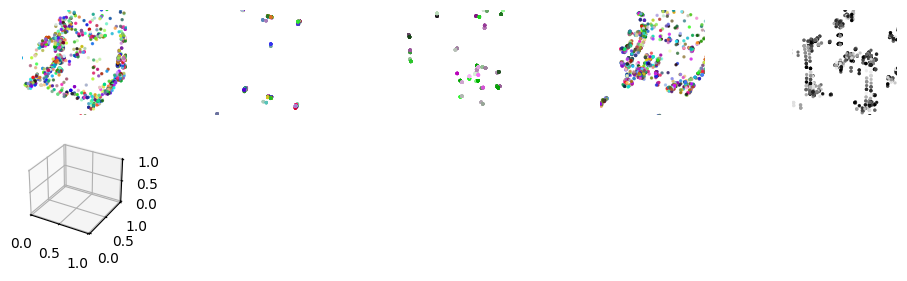

In [27]:
train_loss_list = []  
test_loss_list = []  
loss_list = []
counter = 0

for i in range(100) :

    startTime = time.time()
    
    train_loss = train_epoch() #train one epoch, get the average loss
    train_loss_list.append(train_loss)
    
    test_loss = test_epoch() # test with test set
    test_loss_list.append(test_loss)
    
    epoch_time = time.time() - startTime
    
    writeString = "epoch " + str(i) + " train loss : " + str(train_loss) + " test loss : " + str(test_loss) + " epoch time : " + str(epoch_time) + "\n"
    
    #increments counter
    counter += 1

    #prints and saves loss of every 20th iteration
    loss_list.append(train_loss)
    if counter % 20 == 0:
        print(f'Iteration {counter}, Loss: {train_loss}')
        print(output_folder)
        torch.save(net.state_dict(), 'Generalv2_1028pc_Encoder.pth')
    # plot train/test loss graph
    plt.plot(train_loss_list, label="Train")
    plt.plot(test_loss_list, label="Test")
    plt.legend()

    if(save_results): # save all outputs to the save folder

        # write the text output to file
        with open(output_folder + "prints.txt","a") as file: 
            
            file.write(writeString)

        # update the loss graph
        plt.savefig(output_folder + "loss.png")
        plt.close()

        # save input/output as image file
        if(i%50==0):
            
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_test_set"))

            #If you wanted to plot the training outputs aswell
            #train_samples = next(iter(train_loader))
            #loss , train_output = test_batch(train_samples)
            #utils.plotPCbatch(train_samples, train_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_train_set"))
    else : # display all outputs
        
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_test_set"))

            
            train_samples = next(iter(train_loader))
            loss , train_output = test_batch(train_samples)
            utils.plotPCbatch(train_samples, train_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_train_set"))

            print(writeString)

            plt.show()

    #Added a clear cache for me gpu
    torch.cuda.empty_cache()


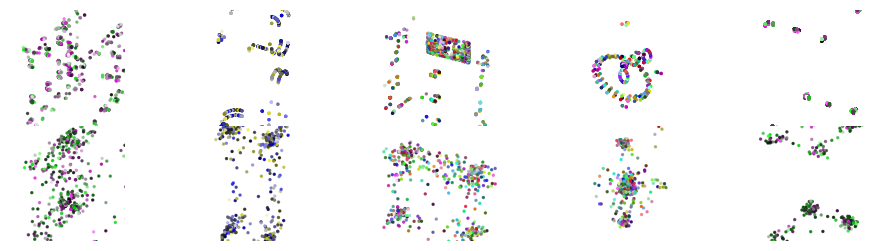

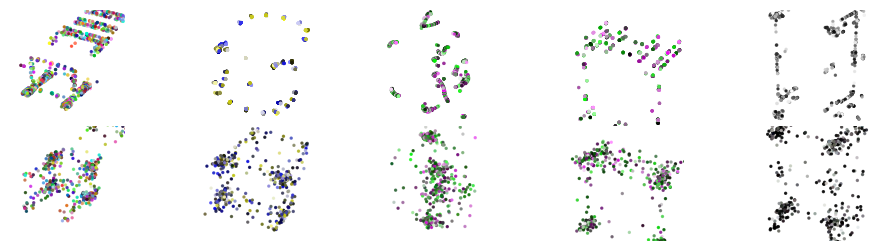

epoch 99 train loss : 0.013516446642577649 test loss : 0.0199925630087299 epoch time : 2.7607898712158203



In [5]:
test_samples = next(iter(test_loader))
loss , test_output = test_batch(test_samples)
utils.plotPCbatch(test_samples, test_output)
            
train_samples = next(iter(train_loader))
loss , train_output = test_batch(train_samples)
utils.plotPCbatch(train_samples, train_output)

print(writeString)

plt.show()

In [14]:
print(output_folder)
torch.save(net.state_dict(), 'Generalv2_1028pc_Encoder.pth')

print(writeString)

plt.show()

/home/lee-ostadi/meoutputsv2_2.1/
epoch 168 train loss : 0.003385062258119785 test loss : 0.010743782040663064 epoch time : 5.0824971199035645



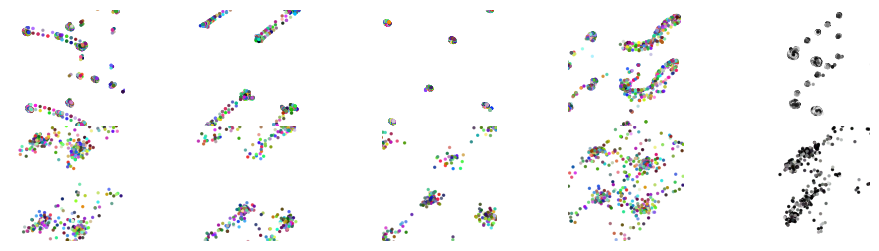

epoch 99 train loss : 0.013516446642577649 test loss : 0.0199925630087299 epoch time : 2.7607898712158203



In [3]:
test_samples = next(iter(test_loader))
loss , test_output = test_batch(test_samples)
utils.plotPCbatch(test_samples,test_output)

print(writeString)

plt.show()


#torch.save(net.state_dict(), '/home/lee-ostadi/me1stnet.pth')


ValueError: RGBA values should be within 0-1 range

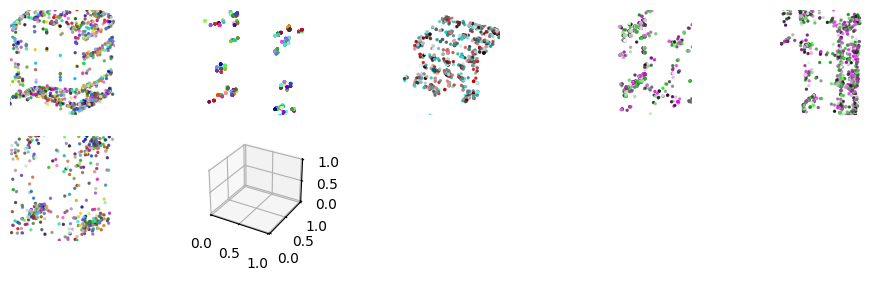

In [23]:
train_samples = next(iter(train_loader))
loss , train_output = test_batch(train_samples)
utils.plotPCbatch(train_samples, train_output)
print(writeString)

plt.show()


In [26]:
print(f"test_samples shape: {test_samples.shape}")
print(f"test_output shape: {test_output.shape}")
print(f"test_samples RGB range: min={test_samples[..., 3:].min()}, max={test_samples[..., 3:].max()}")
print(f"test_output RGB range: min={test_output[..., 3:].min()}, max={test_output[..., 3:].max()}")



test_samples shape: torch.Size([32, 1028, 6])
test_output shape: torch.Size([32, 1028, 6])
test_samples RGB range: min=0.0, max=0.9999674558639526
test_output RGB range: min=-0.049504589289426804, max=1.0778722763061523


NameError: name 'colors' is not defined

In [3]:
#--working v2 training code--#
import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from pytorch3d.loss import chamfer_distance
from RGB_model import PointCloudAE
from Dataloadersv2 import GetDataLoaders
import RGB_utils as utils
import matplotlib.pyplot as plt
import random
import math
import time

# Configuration
batch_size = 32
output_folder = os.path.expanduser("~/meoutputsv2_2.2/")
os.makedirs(output_folder, exist_ok=True)
save_results = True
use_GPU = True
latent_size = 128
fixed_size = 1028

# Utility functions
def generate_random_function():
    functions = [
        lambda x, y, z: (x + y + z) % 1.0,
        lambda x, y, z: (math.sin(x) + math.cos(y) + z) % 1.0,
        lambda x, y, z: (x * y * z) % 1.0,
        lambda x, y, z: ((x**2 + y**2 + z**2)**0.5) % 1.0,
    ]
    return random.choice(functions)

def normalize_point_cloud(pc_array):
    normalized_pc_array = []
    for pc in pc_array:
        spatial_coords = pc[:, :3]
        centroid = np.mean(spatial_coords, axis=0)
        spatial_coords -= centroid
        d_max = np.max(np.linalg.norm(spatial_coords, axis=1))
        if d_max > 0:
            spatial_coords /= d_max
        pc[:, :3] = spatial_coords
        normalized_pc_array.append(pc)
    return np.array(normalized_pc_array)

def assign_color_to_point_clouds(pc_array):
    colored_pc_array = []
    for pc in pc_array:
        r_func, g_func, b_func = generate_random_function(), generate_random_function(), generate_random_function()
        rgb_values = np.array([
            [max(0, min(1, r_func(x, y, z))),
             max(0, min(1, g_func(x, y, z))),
             max(0, min(1, b_func(x, y, z)))]
            for x, y, z in pc
        ])
        colored_pc = np.hstack((pc, rgb_values))
        colored_pc_array.append(colored_pc)
    return np.array(colored_pc_array)

def adjust_point_clouds(pc_array, fixed_size=1028):
    adjusted_pc_array = []
    for pc in pc_array:
        num_points = pc.shape[0]
        if num_points < fixed_size:
            indices = np.random.choice(num_points, fixed_size - num_points, replace=True)
            upsampled_points = pc[indices, :]
            adjusted_pc = np.vstack((pc, upsampled_points))
        elif num_points > fixed_size:
            indices = np.random.choice(num_points, fixed_size, replace=False)
            adjusted_pc = pc[indices, :]
        else:
            adjusted_pc = pc
        adjusted_pc_array.append(adjusted_pc)
    return np.array(adjusted_pc_array)

# Load, normalize, and prepare point clouds
def preprocess_point_clouds(input_path, output_path, fixed_size=1028):
    pc_array = np.load(input_path, allow_pickle=True)
    colored_pc_array = assign_color_to_point_clouds(pc_array)
    adjusted_pc_array = adjust_point_clouds(colored_pc_array, fixed_size=fixed_size)
    normalized_pc_array = normalize_point_cloud(adjusted_pc_array)
    
    np.save(output_path, normalized_pc_array)
    return normalized_pc_array

# Load datasets
test_path = "data/ModelNet10/alltest.npy"
train_path = "data/ModelNet10/alltrain.npy"
test_output_path = "data/alltest_adjusted.npy"
train_output_path = "data/alltrain_adjusted.npy"

adjusted_pc_test_array = preprocess_point_clouds(test_path, test_output_path, fixed_size=fixed_size)
adjusted_pc_train_array = preprocess_point_clouds(train_path, train_output_path, fixed_size=fixed_size)

# Load DataLoaders
train_loader, test_loader = GetDataLoaders(
    train_source =train_output_path,
    test_source =test_output_path,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)

# Initialize the network
point_size = fixed_size
net = PointCloudAE(point_size, latent_size)
if os.path.isfile('General_rgb_1028pc_Encoder.pth'):
    net.load_state_dict(torch.load('General_rgb_1028pc_Encoder.pth'))
    print("Loaded saved model weights.")
else:
    print("No saved model weights found. Starting from scratch.")

device = torch.device("cuda:0" if use_GPU and torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    net = torch.nn.DataParallel(net)
net = net.to(device)

# Training setup
optimizer = optim.Adam(net.parameters(), lr=0.0006)

# Loss function
def combined_loss(pred, target):
    pred_spatial, pred_color = pred[..., :3], pred[..., 3:]
    target_spatial, target_color = target[..., :3], target[..., 3:]
    spatial_loss, _ = chamfer_distance(pred_spatial, target_spatial)
    color_loss, _ = chamfer_distance(pred_color, target_color)
    return spatial_loss + color_loss

def train_epoch():
    net.train()
    epoch_loss = 0

    # Loop over the data returned by the DataLoader
    for i, batch in enumerate(train_loader):
        # Handle the batch structure
        if isinstance(batch, (tuple, list)):  # If train_loader returns tuples
            data = batch[0]  # Extract the data
        else:
            data = batch  # If train_loader returns only the data

        # Move data to the device (GPU/CPU)
        data = data.to(device)

        # Zero the optimizer gradients
        optimizer.zero_grad()

        # Pass the data through the network (transpose for N, C, L format)
        output = net(data.permute(0, 2, 1))

        # Compute the loss
        loss = combined_loss(output, data)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()

    # Return the average loss
    return epoch_loss / len(train_loader)


def test_epoch():
    net.eval()  # Set the network to evaluation mode
    epoch_loss = 0

    with torch.no_grad():  # Disable gradient computation
        for i, batch in enumerate(test_loader):
            # Handle the batch structure
            if isinstance(batch, (tuple, list)):  # If test_loader returns tuples
                data = batch[0]  # Extract the data
            else:
                data = batch  # If test_loader returns only the data

            # Move data to the device (GPU/CPU)
            data = data.to(device)

            # Pass the data through the network (transpose for N, C, L format)
            output = net(data.permute(0, 2, 1))

            # Compute the loss
            loss = combined_loss(output, data)

            # Accumulate the loss
            epoch_loss += loss.item()

    # Return the average loss
    return epoch_loss / len(test_loader)


# Training loop
"""
train_losses, test_losses = [], []
for epoch in range(100):
    train_loss = train_epoch()
    test_loss = test_epoch()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch}: Train Loss = {train_loss}, Test Loss = {test_loss}")
    torch.save(net.state_dict(), f"epoch_{epoch}_model.pth")
"""
def test_batch(data): # test with a batch of inputs
    with torch.no_grad():
        
        data = data.to(device)
        output = net(data.permute(0,2,1))
        #loss, _ = chamfer_distance(data, output)
        loss = combined_loss(data, output)
        
    return loss.item(), output.cpu()

def test_epoch(): # test with all test set
    with torch.no_grad():
        epoch_loss = 0
        for i, data in enumerate(test_loader):
            
            loss, output = test_batch(data)
            epoch_loss += loss

    return epoch_loss/i

train_loss_list = []  
test_loss_list = []  
loss_list = []
counter = 0

for i in range(500) :

    startTime = time.time()
    
    train_loss = train_epoch() #train one epoch, get the average loss
    train_loss_list.append(train_loss)
    
    test_loss = test_epoch() # test with test set
    test_loss_list.append(test_loss)
    
    epoch_time = time.time() - startTime
    
    writeString = "epoch " + str(i) + " train loss : " + str(train_loss) + " test loss : " + str(test_loss) + " epoch time : " + str(epoch_time) + "\n"
    
    #increments counter
    counter += 1

    #prints and saves loss of every 20th iteration
    loss_list.append(train_loss)
    if counter % 20 == 0:
        print(f'Iteration {counter}, Loss: {train_loss}')
        print(output_folder)
        torch.save(net.state_dict(), 'General_rgb_1028pc_Encoder.pth')
    # plot train/test loss graph
    plt.plot(train_loss_list, label="Train")
    plt.plot(test_loss_list, label="Test")
    plt.legend()

    if(save_results): # save all outputs to the save folder

        # write the text output to file
        with open(output_folder + "prints.txt","a") as file: 
            
            file.write(writeString)

        # update the loss graph
        plt.savefig(output_folder + "loss.png")
        plt.close()

        # save input/output as image file
        if(i%50==0):
            
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_test_set"))

            #If you wanted to plot the training outputs aswell
            #train_samples = next(iter(train_loader))
            #loss , train_output = test_batch(train_samples)
            #utils.plotPCbatch(train_samples, train_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_train_set"))
    else : # display all outputs
        
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_test_set"))

            
            train_samples = next(iter(train_loader))
            loss , train_output = test_batch(train_samples)
            utils.plotPCbatch(train_samples, train_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_train_set"))

            print(writeString)

            plt.show()

    #Added a clear cache for me gpu
    torch.cuda.empty_cache()


/tmp/ipykernel_30425/1554899348.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(colored_pc_array)


No saved model weights found. Starting from scratch.
Iteration 20, Loss: 0.021063533157110213
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 40, Loss: 0.01784657272696495
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 60, Loss: 0.015480102121829986
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 80, Loss: 0.014075468353927135
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 100, Loss: 0.013097524158656598
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 120, Loss: 0.012785954043269158
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 140, Loss: 0.011970999717712403
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 160, Loss: 0.011566750138998032
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 180, Loss: 0.011047239437699318
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 200, Loss: 0.010930993005633355
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 220, Loss: 0.01068632710725069
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 240, Loss: 0.010409901939332486
/home/lee-ostadi/meoutputsv2_2.2/
Iteration 260, Loss: 0.010360378362238408

In [4]:
train_loss_list = []  
test_loss_list = []  
loss_list = []
counter = 0
torch.autograd.set_detect_anomaly(True)

for i in range(100) :

    startTime = time.time()
    
    train_loss = train_epoch() #train one epoch, get the average loss
    train_loss_list.append(train_loss)
    
    test_loss = test_epoch() # test with test set
    test_loss_list.append(test_loss)
    
    epoch_time = time.time() - startTime
    
    writeString = "epoch " + str(i) + " train loss : " + str(train_loss) + " test loss : " + str(test_loss) + " epoch time : " + str(epoch_time) + "\n"
    
    #increments counter
    counter += 1

    #prints and saves loss of every 20th iteration
    loss_list.append(train_loss)
    if counter % 20 == 0:
        print(f'Iteration {counter}, Loss: {train_loss}')
        print(output_folder)
        torch.save(net.state_dict(), 'Generalv2_1028pc_Encoder.pth')
    # plot train/test loss graph
    plt.plot(train_loss_list, label="Train")
    plt.plot(test_loss_list, label="Test")
    plt.legend()

    if(save_results): # save all outputs to the save folder

        # write the text output to file
        with open(output_folder + "prints.txt","a") as file: 
            
            file.write(writeString)

        # update the loss graph
        plt.savefig(output_folder + "loss.png")
        plt.close()

        # save input/output as image file
        if(i%50==0):
            
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_test_set"))

            #If you wanted to plot the training outputs aswell
            #train_samples = next(iter(train_loader))
            #loss , train_output = test_batch(train_samples)
            #utils.plotPCbatch(train_samples, train_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_train_set"))
    else : # display all outputs
        
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_test_set"))

            
            train_samples = next(iter(train_loader))
            loss , train_output = test_batch(train_samples)
            utils.plotPCbatch(train_samples, train_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_train_set"))

            print(writeString)

            plt.show()

    #Added a clear cache for me gpu
    torch.cuda.empty_cache()

/home/lee-ostadi/miniconda3/envs/3dAE_env/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Error detected in ClampBackward1. Traceback of forward call that caused the error:
  File "/home/lee-ostadi/miniconda3/envs/3dAE_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/lee-ostadi/miniconda3/envs/3dAE_env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/lee-ostadi/miniconda3/envs/3dAE_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/lee-ostadi/miniconda3/envs/3dAE_env/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/lee-ostadi/miniconda3/envs/3dAE_env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/lee-ostadi/miniconda3/envs/3dAE_env/lib/python3.9/

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [32, 1028, 3]], which is output 0 of AsStridedBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!